In [ ]:
from __future__ import print_function
import glob, os, gc, sys
import os.path
import csv
import numpy as np
np.random.seed(1337)  # for reproducibility
from time import time
from subprocess import (call, Popen, PIPE)
from itertools import product
from IPython.display import display
from PIL import Image
from IPython.display import Image as IPImage
import shutil
import re
import xml.etree.ElementTree as ET
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.utils import np_utils
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from keras.layers import Lambda, concatenate
from keras import Model
from keras.models import load_model

##Path to Data
basepath = "/home/ubuntu/salk-logg-bsmn/efs/SLAV_Data/"  
Bulk_1571_Cerebellum = "1571_cereb_BT_40_L3"
Bulk_1571_Hippocampus = "1571_hippo_BT_41_L3"
Bulk_1846_Cerebellum = "1846_cereb_BT_13_L3"
Bulk_1846_Cortex = "1846_cortex_BT_71_L3"
Bulk_1846_Hippocampus = "1846_hippo_BT_19_L3"
Bulk_1846_Liver = "1846_liver_BT_22_L3"
Bulk_5125_Cortex = "5125_cortex_BT_122_L3"
Bulk_5125_Hippocampus = "5125_hippo_BT_139_L3"
Bulk_5125_Liver = "5125_liver_BT_164_L3"

SC_1571_Hippo = ["1571_hippo_SC_43_L3","1571_hippo_SC_45_L3","1571_hippo_SC_46_L3","1571_hippo_SC_47_L3","1571_hippo_SC_48_L3","1571_hippo_SC_50_L3","1571_hippo_SC_51_L3","1571_hippo_SC_52_L3","1571_hippo_SC_53_L3","1571_hippo_SC_55_L3","1571_hippo_SC_56_L3","1571_hippo_SC_57_L3","1571_hippo_SC_58_L3","1571_hippo_SC_59_L3","1571_hippo_SC_61_L3","1571_hippo_SC_62_L3","1571_hippo_SC_63_L3","1571_hippo_SC_64_L3"]
SC_1846_Cortex = ["1846_cortex_SC_72_L3","1846_cortex_SC_73_L3","1846_cortex_SC_74_L3","1846_cortex_SC_75_L3","1846_cortex_SC_78_L3","1846_cortex_SC_79_L3","1846_cortex_SC_80_L3","1846_cortex_SC_81_L3","1846_cortex_SC_82_L3","1846_cortex_SC_83_L3","1846_cortex_SC_84_L3","1846_cortex_SC_85_L3","1846_cortex_SC_86_L3"]
SC_1846_Hippo = ["1846_hippo_SC_100_L3","1846_hippo_SC_101_L3","1846_hippo_SC_102_L3","1846_hippo_SC_103_L3","1846_hippo_SC_104_L3","1846_hippo_SC_105_L3","1846_hippo_SC_106_L3","1846_hippo_SC_107_L3","1846_hippo_SC_108_L3","1846_hippo_SC_109_L3","1846_hippo_SC_110_L3","1846_hippo_SC_111_L3","1846_hippo_SC_112_L3","1846_hippo_SC_113_L3","1846_hippo_SC_88_L3","1846_hippo_SC_89_L3","1846_hippo_SC_90_L3","1846_hippo_SC_91_L3","1846_hippo_SC_92_L3","1846_hippo_SC_93_L3","1846_hippo_SC_94_L3","1846_hippo_SC_95_L3","1846_hippo_SC_99_L3"]
SC_5125_Cortex = ["5125_cortex_SC_125_L3","5125_cortex_SC_126_L3","5125_cortex_SC_127_L3","5125_cortex_SC_128_L3","5125_cortex_SC_129_L3","5125_cortex_SC_130_L3","5125_cortex_SC_131_L3","5125_cortex_SC_132_L3","5125_cortex_SC_133_L3","5125_cortex_SC_134_L3","5125_cortex_SC_135_L3","5125_cortex_SC_136_L3","5125_cortex_SC_138_L3"]
SC_5125_Hippo = ["5125_hippo_SC_140_L3","5125_hippo_SC_141_L3","5125_hippo_SC_142_L3","5125_hippo_SC_143_L3","5125_hippo_SC_144_L3","5125_hippo_SC_145_L3","5125_hippo_SC_147_L3","5125_hippo_SC_149_L3","5125_hippo_SC_150_L3","5125_hippo_SC_151_L3","5125_hippo_SC_152_L3","5125_hippo_SC_153_L3","5125_hippo_SC_154_L3","5125_hippo_SC_155_L3","5125_hippo_SC_156_L3","5125_hippo_SC_157_L3","5125_hippo_SC_158_L3","5125_hippo_SC_159_L3","5125_hippo_SC_160_L3","5125_hippo_SC_161_L3","5125_hippo_SC_162_L3","5125_hippo_SC_163_L3"]


Data_Set_Train = []
Data_Set_Validate = []
Data_Set_Train.append([SC_1571_Hippo,Bulk_1571_Hippocampus,Bulk_1571_Cerebellum])
Data_Set_Train.append([SC_1846_Cortex,Bulk_1846_Cortex,Bulk_1846_Liver])
Data_Set_Train.append([SC_1846_Hippo,Bulk_1846_Hippocampus,Bulk_1846_Liver])
Data_Set_Train.append([SC_5125_Cortex,Bulk_5125_Cortex,Bulk_5125_Liver])
#Data_Set_Validate.append([SC_5125_Hippo,Bulk_5125_Hippocampus,Bulk_5125_Liver])

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

model = load_model('/home/ubuntu/salk-logg-bsmn/efs/BSMN_Project/slav_incv3_scratch_25.h5')

# parallel_model = multi_gpu_model(model, gpus=8)
# opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
# parallel_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
for dset in Data_Set_Train:    
    for cell in dset[0]:
        print(cell)
        if os.path.isfile(os.path.join(basepath, cell, cell+'_XY.npz')):
            if not os.path.isfile(os.path.join(basepath, cell, cell+'_Features.npz')):
                try:
                    data = np.load(os.path.join(basepath, cell, cell+'_XY.npz'))
                    X = data['X'] / 255
                    #Y = data['Y']
                    #Y = Y[:,np.r_[0:21,33:37]]
                    print(X.shape)
                    feat_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)
                    Z = feat_extractor.predict(X, batch_size = 32)
                    print(Z.shape)
                    np.savez(os.path.join(basepath, cell, cell+'_Features.npz'), Z=Z)
                except: 
                    print("npz is bad")
                    pass

1846_cortex_SC_72_L3
1846_cortex_SC_73_L3
1846_cortex_SC_74_L3
1846_cortex_SC_75_L3
1846_cortex_SC_78_L3
1846_cortex_SC_79_L3
1846_cortex_SC_80_L3
1846_cortex_SC_81_L3
1846_cortex_SC_82_L3
1846_cortex_SC_83_L3
1846_cortex_SC_84_L3
1846_cortex_SC_85_L3
1846_cortex_SC_86_L3
1846_hippo_SC_100_L3
1846_hippo_SC_101_L3
1846_hippo_SC_102_L3
1846_hippo_SC_103_L3
1846_hippo_SC_104_L3
1846_hippo_SC_105_L3
1846_hippo_SC_106_L3
1846_hippo_SC_107_L3
1846_hippo_SC_108_L3
1846_hippo_SC_109_L3
1846_hippo_SC_110_L3
1846_hippo_SC_111_L3
1846_hippo_SC_112_L3
1846_hippo_SC_113_L3
1846_hippo_SC_88_L3
1846_hippo_SC_89_L3
(20287, 512, 512, 3)
(20287, 1024)
1846_hippo_SC_90_L3
(19200, 512, 512, 3)
(19200, 1024)
1846_hippo_SC_91_L3
1846_hippo_SC_92_L3
(19323, 512, 512, 3)
(19323, 1024)
1846_hippo_SC_93_L3
(18230, 512, 512, 3)
(18230, 1024)
1846_hippo_SC_94_L3
(18451, 512, 512, 3)
(18451, 1024)
1846_hippo_SC_95_L3
(19830, 512, 512, 3)
(19830, 1024)
1846_hippo_SC_99_L3
(19000, 512, 512, 3)
(19000, 1024)
5125_cor

In [3]:
count = 0
for dset in Data_Set_Train:    
    for cell in dset[0]:
        print(cell)
        if os.path.isfile(os.path.join(basepath, cell, cell+'_Features.npz')):
            if count == 0:             
                data = np.load(os.path.join(basepath, cell, cell+'_Features.npz'))
                features = data['Z']
#                 data2 = np.load(os.path.join(basepath, cell, cell+'_XY.npz'))
#                 X = data2['X']
                count+=1
                print(features.shape)
#                 print(X.shape)
            else:
                data = np.load(os.path.join(basepath, cell, cell+'_Features.npz'))
                features = np.append(features,data['Z'],axis=0)
#                 data2 = np.load(os.path.join(basepath, cell, cell+'_XY.npz'))
#                 X = np.append(X,data2['X'], axis=0) 
                count+=1
                print(features.shape)
#                 print(X.shape)
                

1571_hippo_SC_43_L3
(16770, 1024)
1571_hippo_SC_45_L3
(35601, 1024)
1571_hippo_SC_46_L3
(45578, 1024)
1571_hippo_SC_47_L3
(61676, 1024)
1571_hippo_SC_48_L3
(81555, 1024)
1571_hippo_SC_50_L3
(100880, 1024)
1571_hippo_SC_51_L3
(119880, 1024)
1571_hippo_SC_52_L3
(138450, 1024)
1571_hippo_SC_53_L3
(154528, 1024)
1571_hippo_SC_55_L3
1571_hippo_SC_56_L3
(177521, 1024)
1571_hippo_SC_57_L3
(196463, 1024)
1571_hippo_SC_58_L3
(218099, 1024)
1571_hippo_SC_59_L3
(235415, 1024)
1571_hippo_SC_61_L3
(251692, 1024)
1571_hippo_SC_62_L3
(266871, 1024)
1571_hippo_SC_63_L3
(284028, 1024)
1571_hippo_SC_64_L3
1846_cortex_SC_72_L3
(302095, 1024)
1846_cortex_SC_73_L3
(319395, 1024)
1846_cortex_SC_74_L3
(336592, 1024)
1846_cortex_SC_75_L3
(349330, 1024)
1846_cortex_SC_78_L3
(370010, 1024)
1846_cortex_SC_79_L3
(388760, 1024)
1846_cortex_SC_80_L3
(407442, 1024)
1846_cortex_SC_81_L3
(423615, 1024)
1846_cortex_SC_82_L3
(444561, 1024)
1846_cortex_SC_83_L3
(461792, 1024)
1846_cortex_SC_84_L3
(477382, 1024)
1846_cort

In [ ]:
from MulticoreTSNE import MulticoreTSNE as TSNE
#from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=2000, n_jobs=8)
tsne_results = tsne.fit_transform(features)
tx, ty = tsne_results[:,0], tsne_results[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

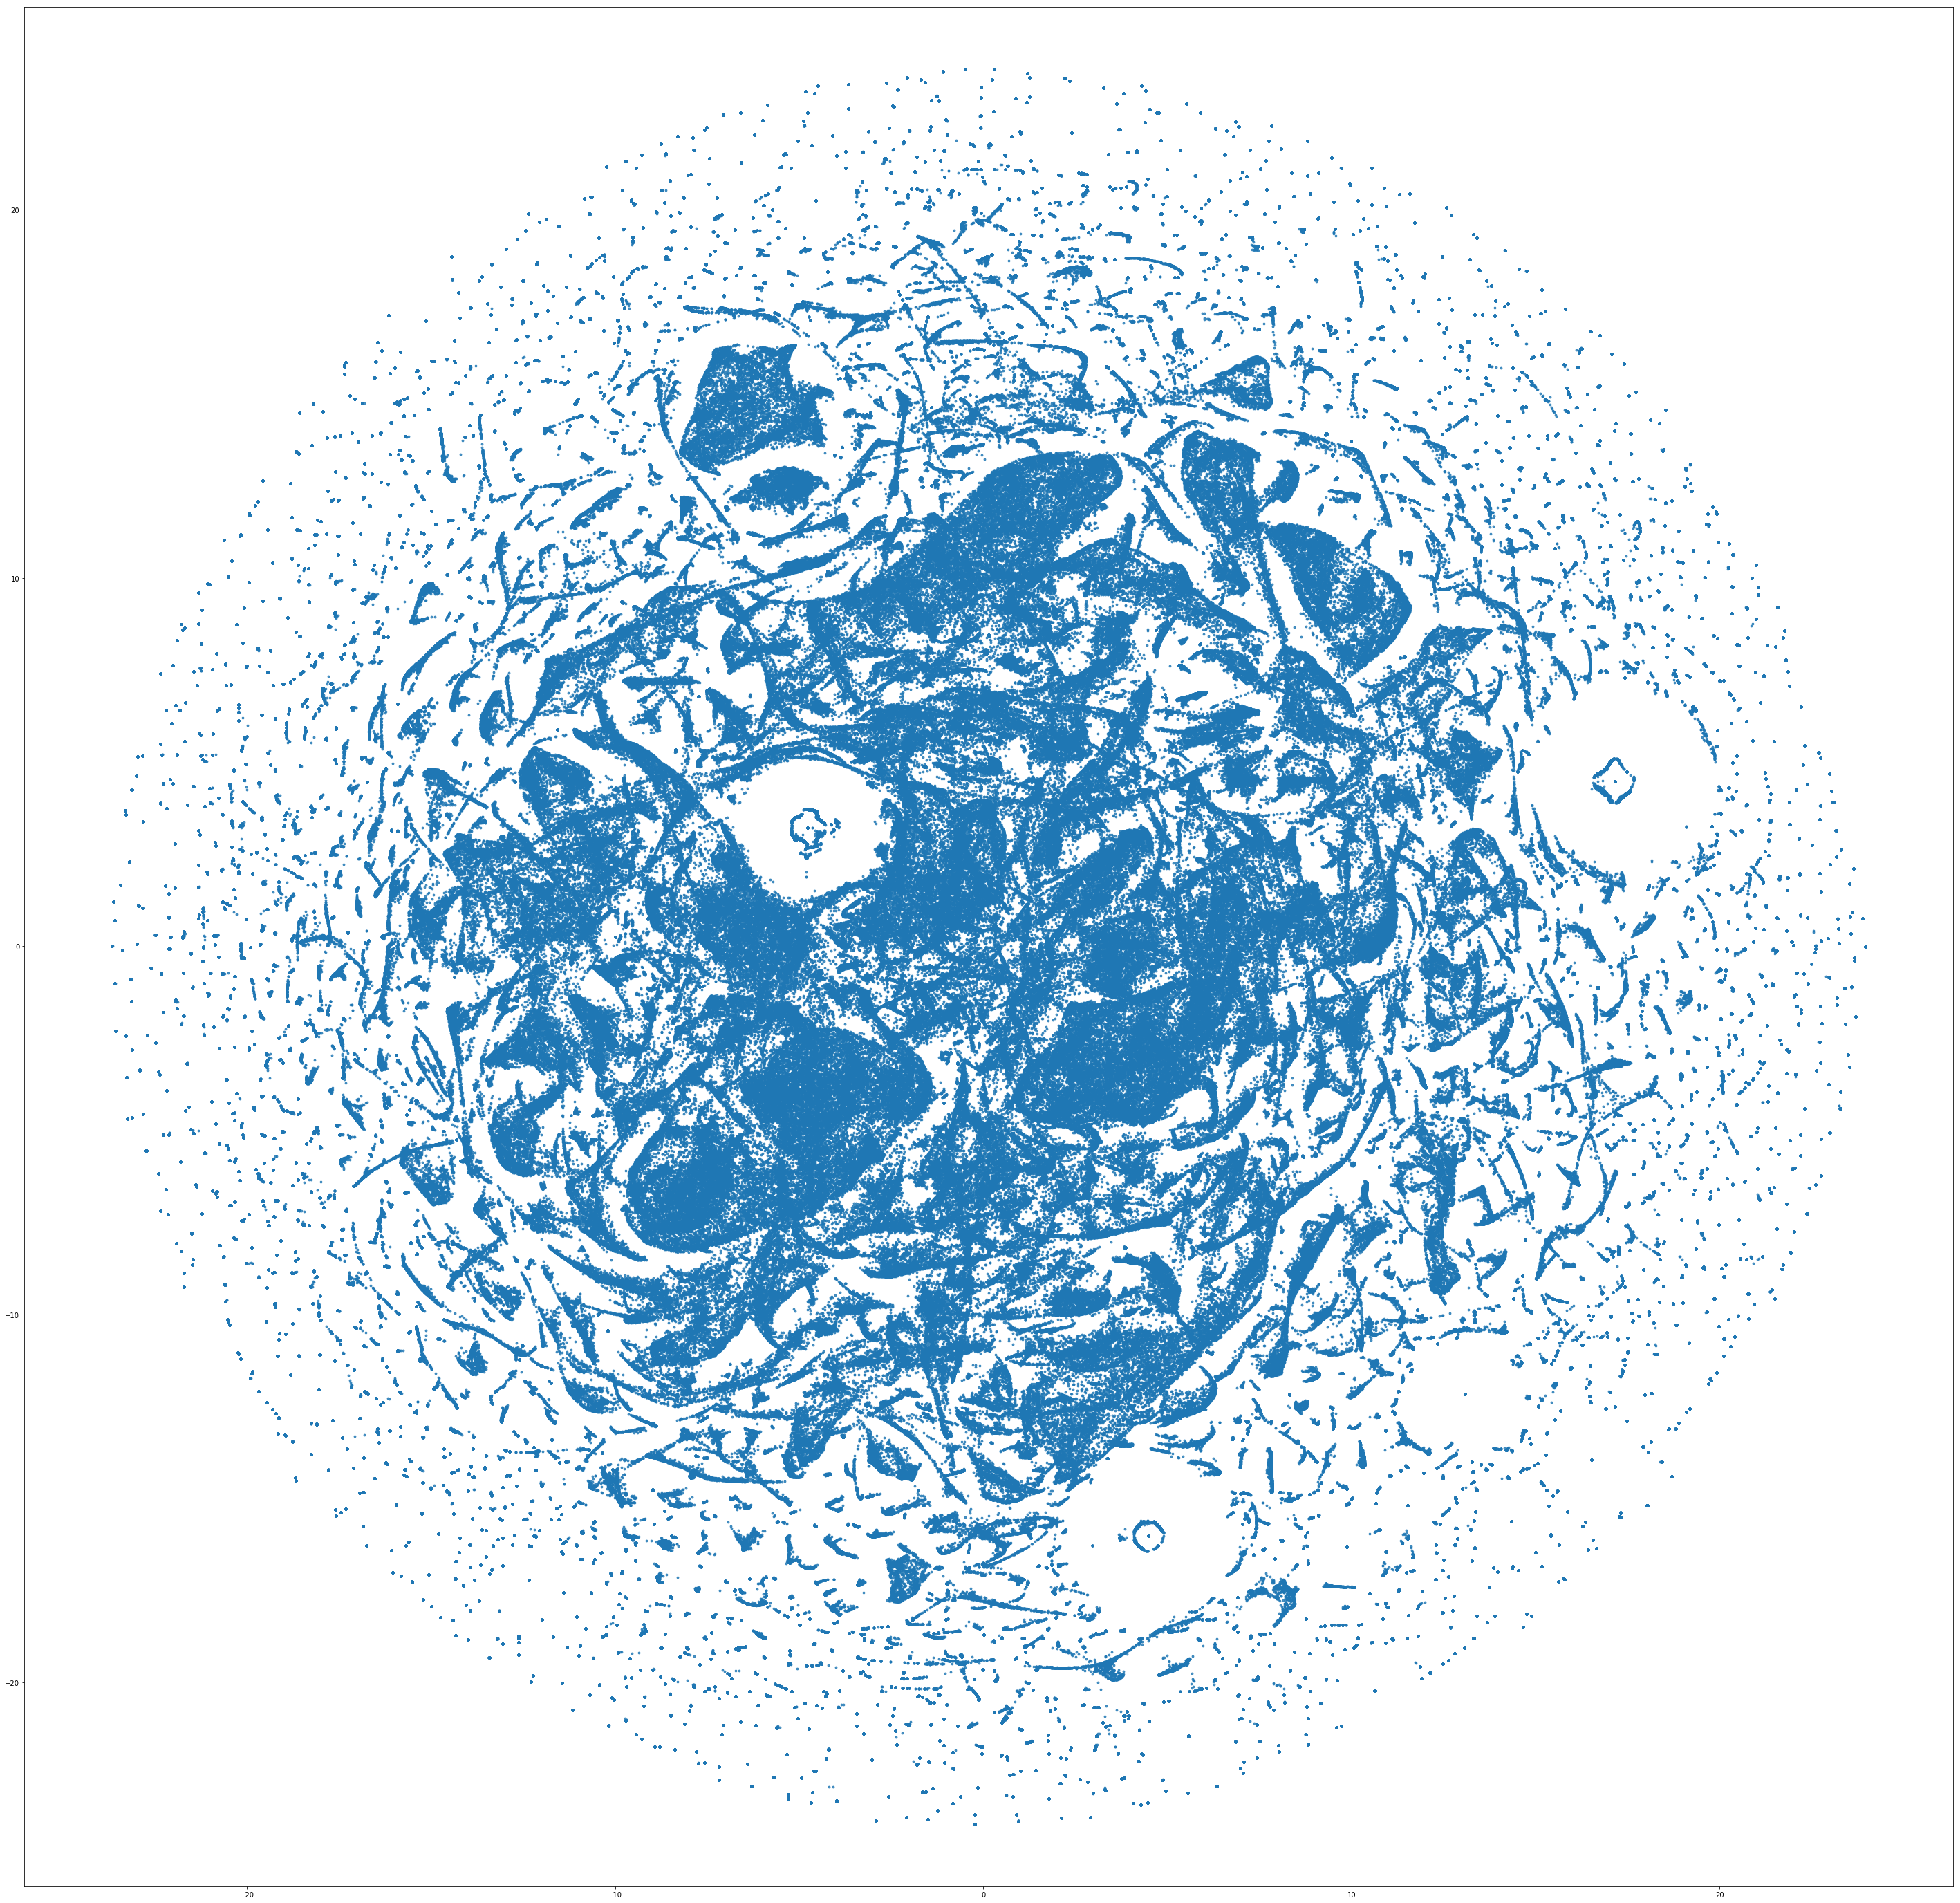

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,50)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.8, s=8)
plt.axis('equal');
plt.show()

In [9]:
np.save(os.path.join(basepath,'tsneResults.npy'), tsne_results)

In [1]:
tsne_results = np.load(os.path.join(basepath,'tsneResults.npy'))

NameError: name 'np' is not defined

In [21]:
from sklearn.cluster import DBSCAN
db = DBSCAN(min_samples=100, eps=.3,n_jobs=24).fit(tsne_results)

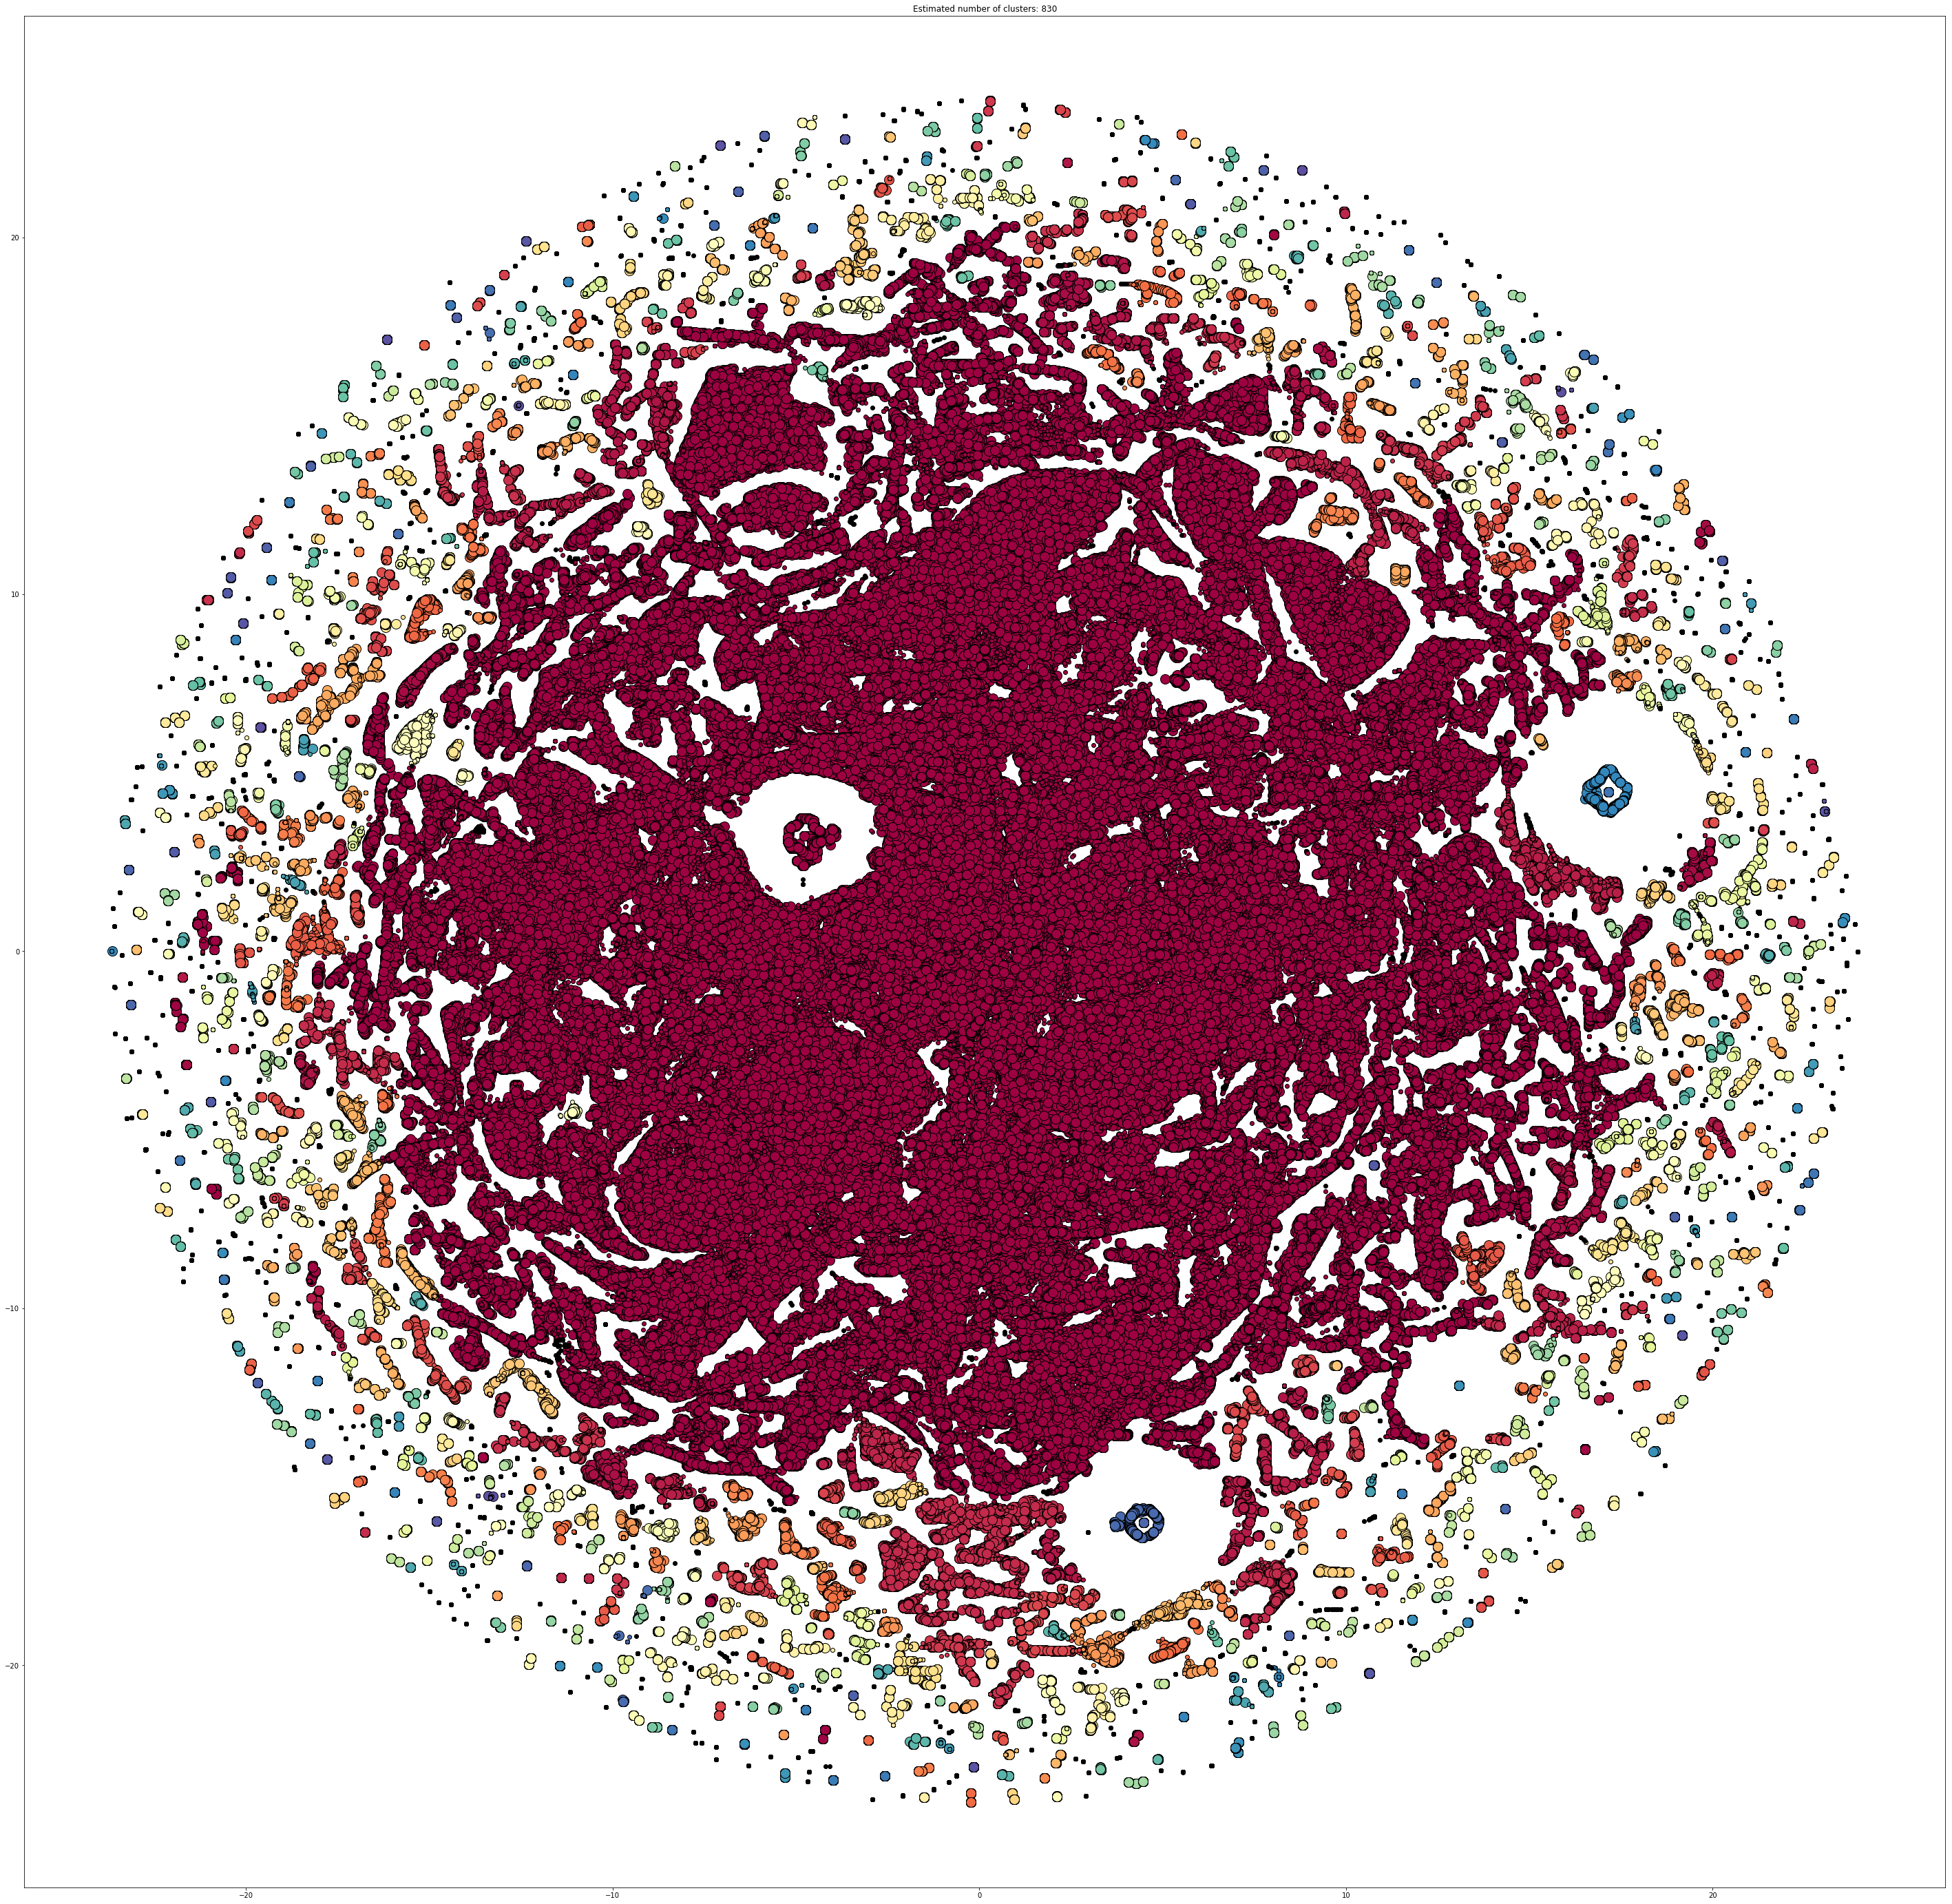

In [22]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = tsne_results[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = tsne_results[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
%matplotlib inline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def visualize_scatter_with_images(X_2d_data, images, figsize=(50,50), image_zoom=.1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

visualize_scatter_with_images(tsne_results, images = X, image_zoom=0.25)

KeyboardInterrupt: 

In [ ]:
from keras.models import load_model
from keras.optimizers import Adam

model = load_model('/home/ubuntu/efs/BSMN_Project/inceptionV3_SLAV_3_2.h5')
basepath = "/home/ubuntu/efs/SLAV_Data/tSNE_Data/"
os.chdir(os.path.join(basepath))
X = np.load('Train_Subset128.npy')

x_train = X.astype('float32')
x_train /= 255

print(x_train.shape)
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

nb_samples = len(x_train)

feat_extractor = Model(inputs=model.input, outputs=model.get_layer('dense_1').output)
features = feat_extractor.predict(x_train, batch_size = 32)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=2, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(features)
tx, ty = tsne_results[:,0], tsne_results[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (50,50)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.8, s=10)
plt.axis('equal');
plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def visualize_scatter_with_images(X_2d_data, images, figsize=(200,200), image_zoom=.5):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

visualize_scatter_with_images(tsne_results, images = X, image_zoom=0.5)

In [ ]:
test_data_dir = os.path.join(basepath, '_Test')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(512,512),
    color_mode = 'rgb',
    batch_size=1,
    class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)
 
predicts = model.predict_generator(test_generator, steps = nb_samples,  workers=30, use_multiprocessing=True)
np.savetxt("predictions.csv", predicts, delimiter=",")

In [ ]:
classes = train_generator.class_indices
classes_new = {val:key for (key, val) in classes.items()}
print(classes_new[1])
filenames = test_generator.filenames
max_val = np.amax(predicts,axis=1)
max_pos = np.argmax(predicts, axis=1)
maxed = np.vstack((max_val, max_pos,filenames)).T
for row in maxed:
    prob = row[0]
    index = row[1]
    file_name = row[2]
    if prob > .9999:
        subfolder = classes_new[int(index)]
        if not os.path.exists(os.path.join(basepath, '_Test/testing',subfolder)):
            os.makedirs(os.path.join(basepath, '_Test/testing',subfolder))
        if os.path.isfile(os.path.join(basepath, '_Test',file_name)):
            shutil.move(os.path.join(basepath, '_Test',file_name), os.path.join(basepath, '_Test/testing',subfolder))